In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

Mounted at /content/drive


In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VNP.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 12s 121ms/step - loss: 0.0174 - val_loss: 0.0027
Epoch 2/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0034 - val_loss: 0.0067
Epoch 3/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0144
Epoch 4/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0018 - val_loss: 0.0115
Epoch 5/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0116
Epoch 6/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 7/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0098
Epoch 8/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0066
Epoch 9/100
12/12 [==============================] - 0s 23ms/step - loss: 0.0016 - val_loss: 0.0084
Epoch 10/100
12/12 [==============================] - 0s 24ms/step - loss: 0.0015 - val_loss: 0.00

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 24ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))


In [12]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

# Tính MAE cho Test và Validate
mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

# Tính MAPE cho Test và Validate
mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100


print('Validation RMSE:', valid_rmse)
print("Validate MAE: ", mae_val)
print("Validate MAPE: ", mape_val)

print('Testing RMSE:', test_rmse)
print("Test MAE: ", mae_test)
print("Test MAPE: ", mape_test)

Validation RMSE: 629.3612592290746
Validate MAE:  499.9287553267039
Validate MAPE:  3.761221072001402
Testing RMSE: 2131.1439013050494
Test MAE:  1889.269888200431
Test MAPE:  13.35906765549458


In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[22:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1




0 day input [0.26666667 0.25555556 0.24814815 0.25185185 0.25925926 0.26296296
 0.27037037 0.24074074 0.24814815 0.25555556 0.24444444 0.24074074
 0.23333333 0.24074074 0.23333333 0.25185185 0.24814815 0.25185185
 0.24444444 0.25925926 0.24444444 0.24814815 0.25185185 0.25185185
 0.26666667 0.27037037 0.27777778 0.26666667 0.27407407 0.28518519
 0.27777778 0.28518519 0.27407407 0.2962963  0.28518519 0.3
 0.28888889 0.3        0.27777778 0.28888889 0.26296296 0.25925926
 0.25555556 0.25925926 0.27777778 0.3        0.27777778 0.25925926
 0.26296296 0.26296296 0.26666667 0.27037037 0.26666667 0.25185185
 0.24814815 0.25925926 0.28148148 0.26666667 0.26296296 0.27777778
 0.25925926 0.25925926 0.25925926 0.25925926 0.24814815 0.31111111
 0.36666667 0.3962963  0.34444444 0.32222222 0.37407407 0.35185185
 0.33703704 0.35925926 0.33703704 0.34444444 0.35185185 0.34444444
 0.32962963 0.31481481 0.34074074 0.32592593 0.31851852 0.32222222
 0.32962963 0.32592593 0.31851852 0.33703704 0.30740741 0

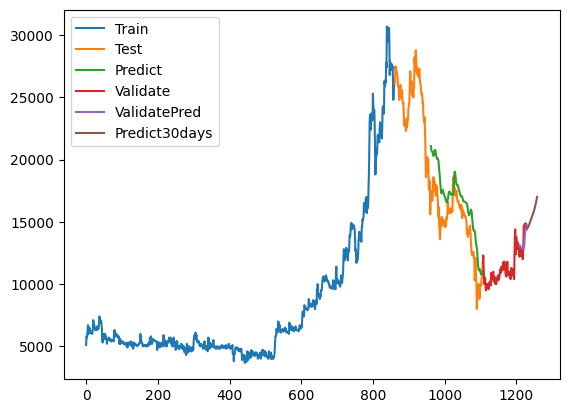

[[14602.84329653]
 [14541.88365936]
 [14524.09900427]
 [14537.692976  ]
 [14574.08787012]
 [14627.75404453]
 [14694.54426765]
 [14771.45392895]
 [14853.0418992 ]
 [14938.76744509]
 [15026.32923126]
 [15112.73552179]
 [15197.34902382]
 [15279.3119669 ]
 [15359.81525183]
 [15438.23606968]
 [15517.79307127]
 [15597.91494608]
 [15680.66967726]
 [15766.28900766]
 [15858.14125538]
 [15954.28074598]
 [16057.35321045]
 [16167.95248985]
 [16286.12686396]
 [16413.94109726]
 [16550.43603182]
 [16696.23930454]
 [16849.07050133]
 [17010.8881712 ]]


In [14]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+ 101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size + 101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# kết quả dự đoán 30 ngày
print(scaler.inverse_transform(lst_output))
